In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_processed_data(train_path='../../data/processed/train_data.csv', 
                       test_path='../../data/processed/test_data.csv'):
    """
    Load preprocessed training and test data
    """
    train = pd.read_csv(train_path, parse_dates=['Datetime'])
    test = pd.read_csv(test_path, parse_dates=['Datetime'])
    
    # Set datetime as index for time series analysis
    train = train.set_index('Datetime')
    test = test.set_index('Datetime')
    
    print("Training data shape:", train.shape)
    print("Test data shape:", test.shape)
    
    return train, test

def check_stationarity(data, column='PJME'):
    """
    Check stationarity using Augmented Dickey-Fuller test
    """
    # Perform ADF test
    result = adfuller(data[column])
    
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    # Plot original time series
    plt.figure(figsize=(12, 6))
    plt.plot(data[column])
    plt.title('Original Time Series')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption')
    plt.show()
    
    # Plot rolling statistics
    rolling_mean = data[column].rolling(window=24).mean()
    rolling_std = data[column].rolling(window=24).std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(data[column], label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Statistics')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption')
    plt.show()

def analyze_acf_pacf(data, column='PJME', lags=40):
    """
    Analyze ACF and PACF plots to determine ARIMA orders
    """
    plt.figure(figsize=(12, 8))
    
    # ACF plot
    plt.subplot(211)
    acf_values = acf(data[column], nlags=lags)
    plt.stem(range(len(acf_values)), acf_values)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    plt.title('Autocorrelation Function')
    
    # PACF plot
    plt.subplot(212)
    pacf_values = pacf(data[column], nlags=lags)
    plt.stem(range(len(pacf_values)), pacf_values)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    plt.title('Partial Autocorrelation Function')
    
    plt.tight_layout()
    plt.show()

def fit_sarima_model(train_data, test_data, order=(2,1,2), seasonal_order=(1,1,1,24), scale_data=True, transform='log'):
    """
    Fit SARIMA model with data transformation options
    transform: 'log' for log transformation, None for no transformation
    """
    """
    Fit SARIMA model with specified orders
    """
    # Scale the data if requested
    # Apply transformation if requested
    if transform == 'log':
        train_values = np.log1p(train_data['PJME'])
    else:
        train_values = train_data['PJME'].copy()
    
    # Scale if requested
    if scale_data:
        scaler = StandardScaler()
        train_scaled = scaler.fit_transform(train_values.values.reshape(-1, 1))
        train_series = pd.Series(train_scaled.flatten(), index=train_data.index)
    else:
        train_series = train_values
    
    # Fit the model
    model = SARIMAX(train_series,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    results = model.fit(disp=False)
    print(results.summary())
    
    # Make predictions
    forecast = results.get_forecast(steps=len(test_data))
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Inverse transform predictions
    if scale_data:
        forecast_mean = scaler.inverse_transform(forecast_mean.values.reshape(-1, 1)).flatten()
        forecast_ci = scaler.inverse_transform(forecast_ci)
    
    if transform == 'log':
        forecast_mean = np.expm1(forecast_mean)
        forecast_ci = np.expm1(forecast_ci)
    
    # Calculate metrics
    mse = mean_squared_error(test_data['PJME'], forecast_mean)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data['PJME'], forecast_mean)
    r2 = r2_score(test_data['PJME'], forecast_mean)
    
    print("\nModel Performance Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index[-100:], train_data['PJME'][-100:], label='Training')
    plt.plot(test_data.index, test_data['PJME'], label='Actual')
    plt.plot(test_data.index, forecast_mean, label='Forecast')
    plt.fill_between(test_data.index,
                    forecast_ci[:, 0] if isinstance(forecast_ci, np.ndarray) else forecast_ci.iloc[:, 0],
                    forecast_ci[:, 1] if isinstance(forecast_ci, np.ndarray) else forecast_ci.iloc[:, 1],
                    color='k', alpha=.2)
    plt.title('SARIMA Forecast vs Actual')
    plt.legend()
    plt.show()
    
    return results, forecast_mean, (rmse, mae, r2)

def perform_residual_analysis(model_results):
    """
    Analyze model residuals
    """
    residuals = model_results.resid
    
    # Plot residuals
    plt.figure(figsize=(12, 8))
    
    # Residuals over time
    plt.subplot(311)
    plt.plot(residuals)
    plt.title('Residuals over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    
    # Residual histogram
    plt.subplot(312)
    residuals.hist(bins=50)
    plt.title('Residual Histogram')
    
    # Q-Q plot
    plt.subplot(313)
    from statsmodels.graphics.gofplots import ProbPlot
    QQ = ProbPlot(residuals)
    QQ.qqplot(line='45')
    plt.title('Q-Q Plot')
    
    plt.tight_layout()
    plt.show()
    
    # Ljung-Box test
    lb_test = acorr_ljungbox(residuals, lags=10)
    print("\nLjung-Box Test Results:")
    print(lb_test)

def grid_search_sarima(train_data, test_data, 
                      p_range=(0,2), d_range=(0,2), q_range=(0,2),
                      P_range=(0,2), D_range=(0,2), Q_range=(0,2),
                      s=24):
    """
    Perform grid search for SARIMA parameters
    """
    best_score = float('inf')
    best_params = None
    best_model = None
    
    results = []
    
    for p in range(p_range[0], p_range[1]+1):
        for d in range(d_range[0], d_range[1]+1):
            for q in range(q_range[0], q_range[1]+1):
                for P in range(P_range[0], P_range[1]+1):
                    for D in range(D_range[0], D_range[1]+1):
                        for Q in range(Q_range[0], Q_range[1]+1):
                            try:
                                model = SARIMAX(train_data['PJME'],
                                              order=(p,d,q),
                                              seasonal_order=(P,D,Q,s),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
                                
                                model_fit = model.fit(disp=False)
                                forecast = model_fit.get_forecast(steps=len(test_data))
                                forecast_mean = forecast.predicted_mean
                                
                                rmse = np.sqrt(mean_squared_error(test_data['PJME'], 
                                                                forecast_mean))
                                
                                results.append({
                                    'order': (p,d,q),
                                    'seasonal_order': (P,D,Q,s),
                                    'rmse': rmse
                                })
                                
                                if rmse < best_score:
                                    best_score = rmse
                                    best_params = ((p,d,q), (P,D,Q,s))
                                    best_model = model_fit
                                    
                                print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - RMSE: {rmse:.2f}")
                                
                            except:
                                continue
    
    results_df = pd.DataFrame(results)
    print("\nBest Model:")
    print(f"Order: {best_params[0]}")
    print(f"Seasonal Order: {best_params[1]}")
    print(f"RMSE: {best_score:.2f}")
    
    return best_model, results_df

def seasonal_decompose(data, column='PJME', period=24):
    """
    Perform seasonal decomposition of time series
    """
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    decomposition = seasonal_decompose(data[column], period=period)
    
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(data[column], label='Original')
    plt.legend(loc='upper right')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='upper right')
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend(loc='upper right')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
    return decomposition

def evaluate_forecast_performance(actual, predicted, title="Forecast Performance Analysis"):
    """
    Comprehensive evaluation of forecast performance
    """
    # Calculate error metrics
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    
    # Print metrics
    print(f"\n{title}")
    print("-" * 50)
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R² Score: {r2:.4f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.scatter(actual, predicted, alpha=0.5)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.tight_layout()
    plt.show()
    
    # Plot error distribution
    errors = predicted - actual
    plt.figure(figsize=(12, 6))
    sns.histplot(errors, kde=True)
    plt.title('Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    return {'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2}

: 

Training data shape: (114565, 28)
Test data shape: (28642, 28)
ADF Statistic: -16.57991767058717
p-value: 1.838091221629235e-29
Critical values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


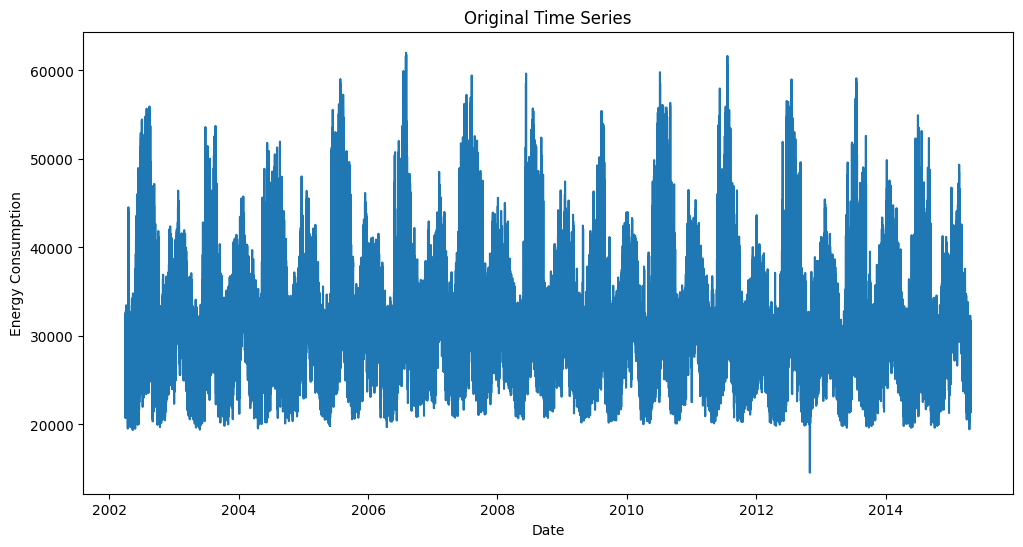

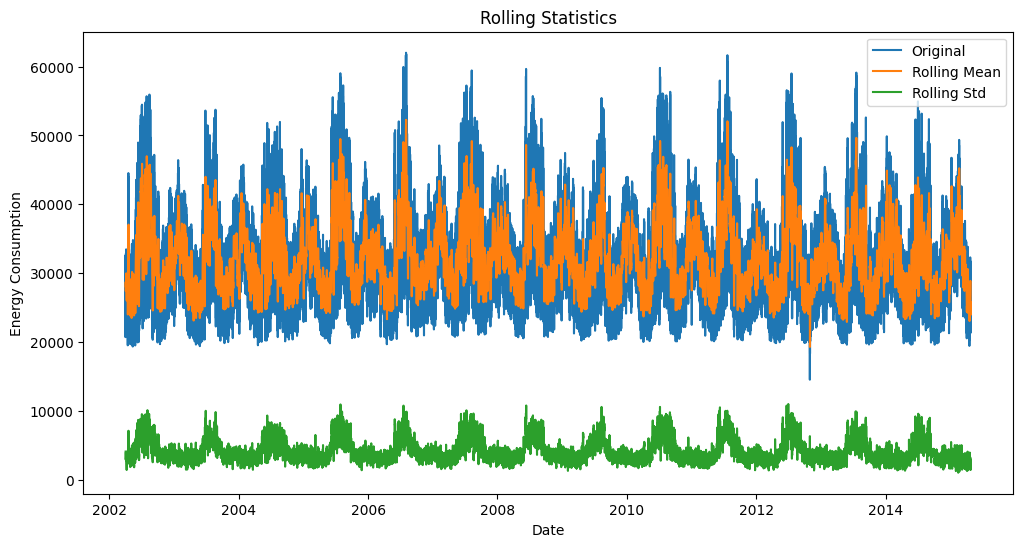

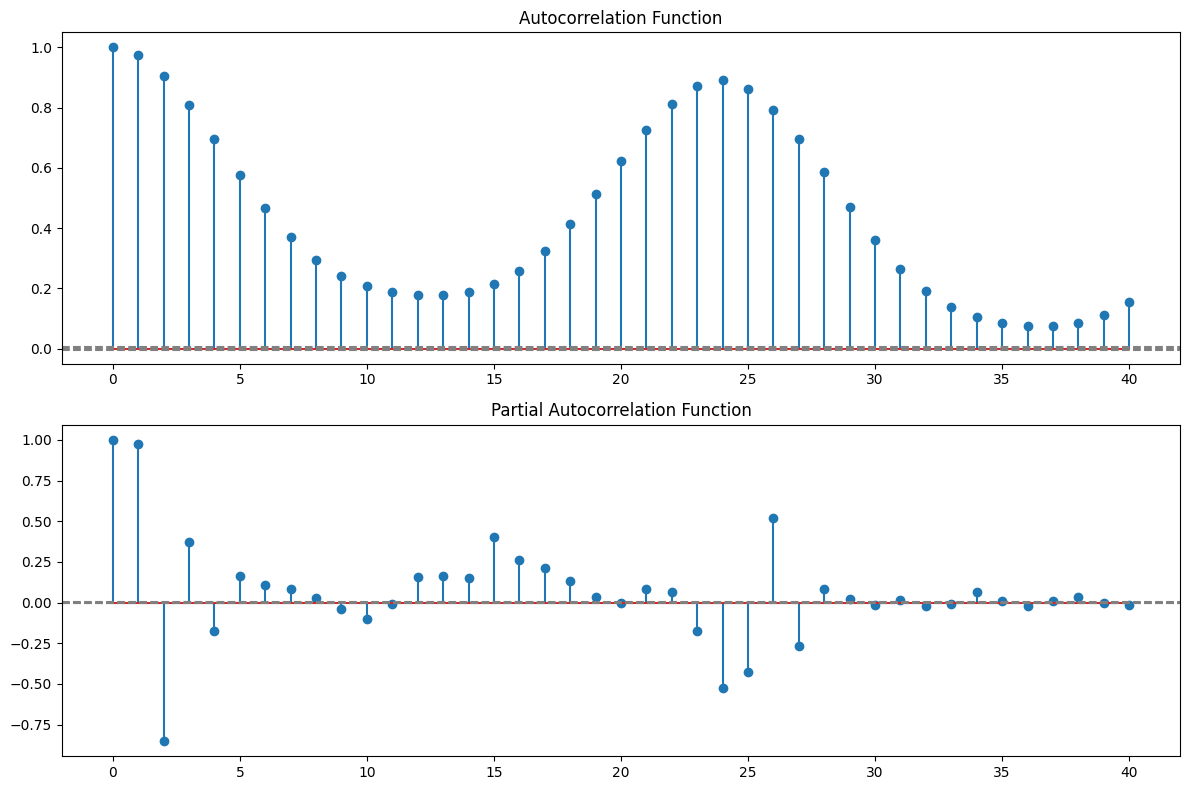

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:               114565
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood              175617.023
Date:                              Mon, 09 Dec 2024   AIC                        -351220.045
Time:                                      14:57:42   BIC                        -351152.506
Sample:                                           0   HQIC                       -351199.673
                                           - 114565                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3583      0.020     18.117      0.000       0.320       0.397
ar.L2         -0.09

In [3]:
# Load data
train_data, test_data = load_processed_data()
    
# Check stationarity
check_stationarity(train_data)
    
# Analyze ACF/PACF
analyze_acf_pacf(train_data)
    
# Fit initial SARIMA model
model_results, forecasts, metrics = fit_sarima_model(train_data, test_data)
    
# Perform residual analysis
perform_residual_analysis(model_results)